In [1]:
import os
import itertools
import shutil
import random

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Activation,Reshape, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.applications import imagenet_utils
from tensorflow.keras.models import load_model
from tensorflow.keras.applications import DenseNet121

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

#https://www.kaggle.com/pmigdal/transfer-learning-with-resnet-50-in-keras

In [2]:
model = DenseNet121()
model.summary()

Model: "densenet121"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
________________________________________________________________________________________

In [3]:
train_path = 'data/train'
valid_path = 'data/valid'
test_path = 'data/test'

train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.densenet.preprocess_input).flow_from_directory(
    directory=train_path, target_size=(224,224), batch_size=32)

valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.densenet.preprocess_input).flow_from_directory(
    directory=valid_path, target_size=(224,224), batch_size=32)
    
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.densenet.preprocess_input).flow_from_directory(
    directory=test_path, target_size=(224,224), batch_size=32, shuffle=False)


Found 6360 images belonging to 5 classes.
Found 795 images belonging to 5 classes.
Found 800 images belonging to 5 classes.


In [4]:
model_d=DenseNet121(weights='imagenet',include_top=False) 

for layer in model_d.layers:
    layer.trainable = False

x=model_d.output

x= GlobalAveragePooling2D()(x)
x= BatchNormalization()(x)
x= Dropout(0.5)(x)
x= Dense(1024,activation='relu')(x) 
x= Dense(512,activation='relu')(x) 
x= BatchNormalization()(x)
x= Dropout(0.5)(x)

preds=Dense(5,activation='softmax')(x)

model=Model(inputs=model_d.input,outputs=preds)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
zero_padding2d_2 (ZeroPadding2D (None, None, None, 3 0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, None, None, 6 9408        zero_padding2d_2[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, None, None, 6 256         conv1/conv[0][0]                 
______________________________________________________________________________________________

In [5]:
model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(x=train_batches,
            steps_per_epoch=len(train_batches),
            validation_data=valid_batches,
            validation_steps=len(valid_batches),
            epochs=15,
            verbose=2
)

Epoch 1/15
199/199 - 643s - loss: 0.7334 - accuracy: 0.7492 - val_loss: 0.2025 - val_accuracy: 0.9509
Epoch 2/15
199/199 - 623s - loss: 0.2635 - accuracy: 0.9097 - val_loss: 0.0611 - val_accuracy: 0.9811
Epoch 3/15
199/199 - 665s - loss: 0.1951 - accuracy: 0.9329 - val_loss: 0.0333 - val_accuracy: 0.9862
Epoch 4/15
199/199 - 651s - loss: 0.1516 - accuracy: 0.9497 - val_loss: 0.0262 - val_accuracy: 0.9874
Epoch 5/15
199/199 - 671s - loss: 0.1309 - accuracy: 0.9549 - val_loss: 0.0181 - val_accuracy: 0.9925
Epoch 6/15
199/199 - 679s - loss: 0.1129 - accuracy: 0.9602 - val_loss: 0.0177 - val_accuracy: 0.9925
Epoch 7/15
199/199 - 698s - loss: 0.1068 - accuracy: 0.9651 - val_loss: 0.0158 - val_accuracy: 0.9937
Epoch 8/15
199/199 - 722s - loss: 0.0828 - accuracy: 0.9711 - val_loss: 0.0147 - val_accuracy: 0.9937
Epoch 9/15
199/199 - 716s - loss: 0.0909 - accuracy: 0.9690 - val_loss: 0.0123 - val_accuracy: 0.9950
Epoch 10/15
199/199 - 728s - loss: 0.0749 - accuracy: 0.9756 - val_loss: 0.0114 - 

In [6]:
model.save('models/resnet_50/model.h5')

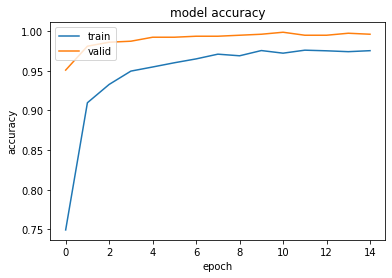

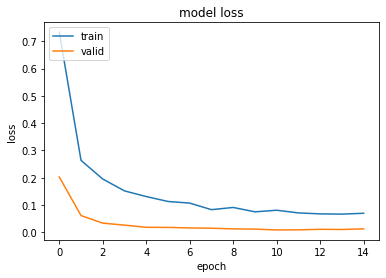

In [7]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

In [8]:
test_labels = test_batches.classes
predictions = model.predict(x=test_batches, steps=len(test_batches), verbose=0)
cm = confusion_matrix(y_true=test_labels, y_pred=predictions.argmax(axis=1))

In [9]:
y_pred_bool = np.argmax(predictions, axis=1)

print(classification_report(test_labels, y_pred_bool))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       160
           1       1.00      1.00      1.00       160
           2       0.99      1.00      1.00       160
           3       1.00      0.99      0.99       160
           4       1.00      0.99      0.99       160

    accuracy                           0.99       800
   macro avg       1.00      0.99      1.00       800
weighted avg       1.00      0.99      1.00       800



In [10]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[160   0   0   0   0]
 [  0 160   0   0   0]
 [  0   0 160   0   0]
 [  1   0   1 158   0]
 [  2   0   0   0 158]]


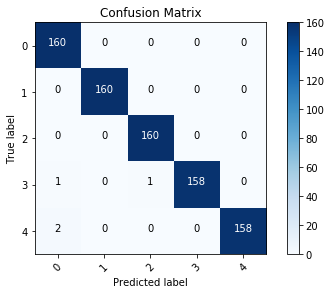

In [11]:
test_batches.class_indices

cm_plot_labels = ['0','1','2','3','4']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')